In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install fasttext

In [3]:
pip install transformers

In [4]:
# importing necessary libraries
import os
import json
import random
import fasttext
import pandas as pd
import seaborn as sns
from math import sqrt
import argparse
import nltk
from nltk.corpus import wordnet
import matplotlib.pyplot as plt
from math import sqrt
import codecs
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [5]:
from gensim.models.fasttext import FastText
from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec
import logging

In [6]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
base_dir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'

# Loading the ground-truth file to get the mapping of known texts to their true authors
ground_truth_file = os.path.join(base_dir, 'ground-truth.json')

# Loading the meta-file to get information about candidate authors
meta_file = os.path.join(base_dir, 'meta-file.json')

# Loading the ground-truth data
with open(ground_truth_file, "r", encoding="utf-8") as json_file:
    ground_truth_data = json.load(json_file)

# Loading the meta data
with open(meta_file, "r", encoding="utf-8") as json_file:
    meta_data = json.load(json_file)

# Listing candidate author folders
candidate_folders = [folder["author-name"] for folder in meta_data["candidate-authors"]]

# Preparing data for FastText
prepared_data = []

# Looping through known text files and their true authors
for item in ground_truth_data["ground-truth"]:
    known_text_filename = item["unknown-text"]
    true_author = item["true-author"]

    # Constructing the file path for the known text
    known_text_path = os.path.join(base_dir, 'unknown', known_text_filename)

    # Reading and process the known text file
    with open(known_text_path, "r", encoding="utf-8") as file:
        known_text_content = file.read()




In [8]:
text_data = []


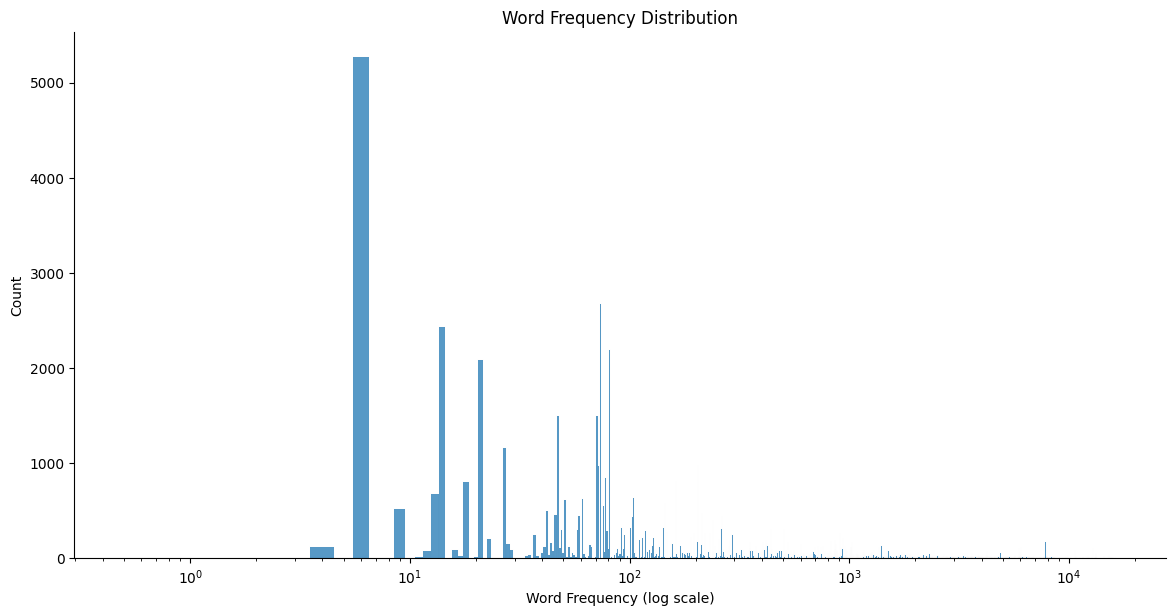

In [9]:

# Define the base directory where your data is located
base_dir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'

# Loading the ground-truth file to get the mapping of known texts to their true authors
ground_truth_file = os.path.join(base_dir, 'ground-truth.json')

# Load the ground-truth data
with open(ground_truth_file, "r", encoding="utf-8") as json_file:
    ground_truth_data = json.load(json_file)

# Prepare data for word frequency analysis
text_data = []

# Iterate through candidate folders
for i, item in enumerate(ground_truth_data["ground-truth"]):
    known_text_filenames = [f"known00001.txt", f"known00002.txt"]  # Known text filenames

    # Construct the file path for the known text files within the candidate folder
    candidate_folder = f'candidate{str(i+1).zfill(5)}'

    for known_text_filename in known_text_filenames:
        known_text_path = os.path.join(base_dir, candidate_folder, known_text_filename)

        # Check if the known text file exists
        if os.path.exists(known_text_path):
            # Read and process the known text file
            try:
                with open(known_text_path, "r", encoding="utf-8") as file:
                    known_text_content = file.read()
            except UnicodeDecodeError:
                print(f"Unable to decode file: {known_text_path}")
                continue

            # Check for missing or empty text content
            if not known_text_content:
                print(f"Missing or empty text content in {known_text_filename}")
            else:
                # Split the content into words
                words = known_text_content.split()

                if not words:
                    print(f"No words found in {known_text_filename}")
                else:
                    text_data.extend(words)

# Check if there are words in the dataset
if len(text_data) == 0:
    print("No words found in the dataset.")
else:
    # Create a DataFrame for word frequency analysis
    word_freq_df = pd.DataFrame(text_data, columns=['word'])

    # Visualize word frequencies
    word_freq = sns.FacetGrid(word_freq_df, aspect=2, height=6)
    word_freq.map(sns.histplot, 'word', kde=False)
    word_freq.set(xscale="log")
    plt.title ("Word Frequency Distribution")
    plt.xlabel ("Word Frequency (log scale)")
    plt.ylabel ("Count")
    plt.show()


In [10]:
df = pd.DataFrame({'text': text_data})

# Checking for missing values in the DataFrame
missing_values = df.isnull().sum()

# Printing the count of missing values for each column
print("Missing Values:")
print(missing_values)

Missing Values:
text    0
dtype: int64


In [11]:
# preparing data for fasttext

In [13]:
prepared_data.append(f"__label__{true_author} {known_text_content}")

# Shuffle the prepared data to ensure randomness
random.shuffle(prepared_data)

# Split the data into a training and validation set
split_index = int(0.8 * len(prepared_data))
training_data = prepared_data[:split_index]
validation_data = prepared_data[split_index:]

# Save the training and validation data to separate files
with open("training_data.txt", "w", encoding="utf-8") as training_file:
    training_file.write("\n".join(training_data))

with open("validation_data.txt", "w", encoding="utf-8") as validation_file:
    validation_file.write("\n".join(validation_data))

# Train a FastText model
model = fasttext.train_supervised(
    input="training_data.txt", epoch=80, lr=0.1, wordNgrams=2, dim=100
)

# Test the model on validation data (you can adapt this part for your specific needs)
results = model.test("validation_data.txt")

# Display the results
print("Validation Results:")
print(f"Number of examples: {results[0]}")
print(f"Precision: {results[1]:.4f}")
print(f"Recall: {results[2]:.4f}")

# Save the model
model.save_model("fasttext_model.bin")

Validation Results:
Number of examples: 4
Precision: 0.7500
Recall: 0.7500


###I Started by training the FastText model using the known texts and validation data.I Made sure to calculate metrics like accuracy, precision, recall, and F1 score on the validation data to evaluate our model's performance.

###(Kopell code)After training the model and evaluating it on validation data,I proceeded to use our model to predict the authors of the unknown texts. Calculate metrics for the unknown texts as well to understand how the model performs on these texts.

In [14]:

base_dir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'

META_FNAME = "meta-file.json"
OUT_FNAME = "answers.json"
GT_FNAME = "ground-truth.json"

# Defineing the paths to your meta-file and ground-truth file
META_FILE_PATH = os.path.join(base_dir, META_FNAME)
GT_FILE_PATH = os.path.join(base_dir, GT_FNAME)

# Arunning this method first to evaluate the meta json file.
def loadJson():
    global corpusdir, upath, candidates, unknowns, encoding, language
    mfile = open(META_FILE_PATH, "r")
    metajson = json.load(mfile)
    mfile.close()

    corpusdir = os.path.dirname(os.path.abspath(META_FILE_PATH))
    upath = os.path.join(corpusdir, metajson["folder"])
    encoding = metajson["encoding"]
    language = metajson["language"]
    candidates = [author["author-name"] for author in metajson["candidate-authors"]]
    unknowns = [text["unknown-text"] for text in metajson["unknown-texts"]]

# Running this method next,if we want to do training (read training files, etc).
def loadTraining():
    for cand in candidates:
        trainings[cand] = []
        for subdir, dirs, files in os.walk(os.path.join(corpusdir, cand)):
            for doc in files:
                trainings[cand].append(doc)

# Getting training text 'fname' from candidate 'cand' (obtain values from 'trainings').
def getTrainingText(cand, fname):
    dfile = codecs.open(os.path.join(corpusdir, cand, fname), "r", "utf-8")
    s = dfile.read()
    dfile.close()
    return s

# Getting training file as bytearray.
def getTrainingBytes(cand, fname):
    dfile = open(os.path.join(corpusdir, cand, fname), "rb")
    b = bytearray(dfile.read())
    dfile.close()
    return b

# Getting unknown text 'fname' (obtain values from 'unknowns').
def getUnknownText(fname):
    dfile = codecs.open(os.path.join(upath, fname), "r", "utf-8")
    s = dfile.read()
    dfile.close()
    return s

# Getting unknown file as bytearray.
def getUnknownBytes(fname):
    dfile = open(os.path.join(upath, fname), "rb")
    b = bytearray(dfile.read())
    dfile.close()
    return b


def storeJson(path, texts, cands, scores=None):
    answers = []
    if scores is None:
        scores = [1 for text in texts]
    for i in range(len(texts)):
        answers.append(
            {"unknown_text": texts[i], "author": cands[i], "score": scores[i]})
    f = open(os.path.join(path, OUT_FNAME), "w")
    json.dump({"answers": answers}, f, indent=2)
    f.close()

def loadGroundTruth():
    tfile = open(GT_FILE_PATH, "r")
    tjson = json.load(tfile)
    tfile.close()

    global trueauthors
    for i in range(len(tjson["ground-truth"])):
        trueAuthors.append(tjson["ground-truth"][i]["true-author"])

# Initializing global variables
encoding = ""
language = ""
corpusdir = ""
upath = ""
candidates = []
unknowns = []
trainings = {}
trueAuthors = []


In [15]:


corpusdir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'
outputdir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'

# Parameters
n = 4
featureLength = 20000
threshold = 0
repetitions = 300
minlen = 0
mintrainlen = 500

# Creating n-grams vector from a string
def createVector(s):
    vector = {}
    words = s.split()
    for word in words:
        if len(word) <= n:
            add(vector, word)
        else:
            for i in range(len(word) - n + 1):
                add(vector, word[i:i + n])
    return vector

# Adding n-grams to the feature list vector
def add(vector, ngram):
    if ngram in vector:
        vector[ngram] += 1
    else:
        vector[ngram] = 1

# Selecting the top x most frequent n-grams/features
def selectFeatures(vector):
    return sorted(vector, key=vector.get, reverse=True)[:min(len(vector), featureLength)]

# Creating a feature map for a given string
def createFeatureMap(s, features):
    fmap = {}
    vec = createVector(s)
    for ngram in features:
        if ngram in vec:
            fmap[ngram] = vec[ngram]
    return fmap

# Calculating cosine similarity
def cosSim(v1, v2):
    sp = float(0)
    len1 = 0
    len2 = 0
    for ngram in v1:
        len1 += v1[ngram] ** 2
    for ngram in v2:
        len2 += v2[ngram] ** 2
    len1 = sqrt(len1)
    len2 = sqrt(len2)
    for ngram in v1:
        if ngram in v2:
            sp += v1[ngram] * v2[ngram]
    return sp / (len1 * len2)

# Calculating minmax similarity
def minmax(v1, v2):
    minsum = 0
    maxsum = 0
    for ngram in v1:
        if ngram in v2:
            minsum += min(v1[ngram], v2[ngram])
            maxsum += max(v1[ngram], v2[ngram])
        else:
            maxsum += v1[ngram]
    for ngram in v2:
        if ngram not in v1:
            maxsum += v2[ngram]
    if maxsum == 0:
        return 0
    return float(minsum) / maxsum

# Training function
def training(s):
    print("Training...")
    vec = createVector(s)
    print("Selecting features...")
    fl = selectFeatures(vec)
    print("Done")
    return fl

# Test similarity
def testSim(x, y, fl, func):
    fx = createFeatureMap(x, fl)
    fy = createFeatureMap(y, fl)
    if func == 0:
        return cosSim(fx, fy)
    else:
        return minmax(fx, fy)

# Gettig a random substring of a given string
def getRandomString(s, length):
    words = s.split()
    r = random.randint(0, len(words) - length)
    return "".join(words[r:r + length])

def main():
    if corpusdir is None or outputdir is None:
        print("Please provide both input and output directories.")
        return
meta_file_path = os.path.join(corpusdir, "meta-file.json")
with open(meta_file_path, "r") as meta_file:
         metajson = json.load(meta_file)
candidates = [author["author-name"] for author in metajson["candidate-authors"]]
unknowns = [text["unknown-text"] for text in metajson["unknown-texts"]]
texts = {}
corpus = ""
deletes = []
for cand in candidates:
        texts[cand] = ""
        for subdir, dirs, files in os.walk(os.path.join(corpusdir, cand)):
            for doc in files:
                with open(os.path.join(corpusdir, cand, doc), "r") as dfile:
                    texts[cand] += dfile.read()
        if len(texts[cand].split()) < mintrainlen:
            del texts[cand]
            deletes.append(cand)
        else:
            corpus += texts[cand]
newcands = [cand for cand in candidates if cand not in deletes]
candidates = newcands
words = [len(texts[cand].split()) for cand in texts]
minwords = min(words)
print(f"Minimum number of words in training texts: {minwords}")
fl = training(corpus)
authors = []
scores = []
for utext in unknowns:
    print(f"Testing {utext}")
    ulen = len(utext.split())
if ulen < minlen:
            authors.append("None")
            scores.append(0)
else:
            wins = [0] * len(candidates)
            textlen = min(ulen, minwords)
            print(f"Text length for testing: {textlen}")
            ustring = "".join(utext.split()[:textlen])
            for i in range(repetitions):
                rfl = random.sample(fl, len(fl) // 2)
                sims = []
                for cand in candidates:
                    candstring = getRandomString(texts[cand], textlen)
                    sims.append(testSim(candstring, ustring, rfl, 1))
                wins[sims.index(max(sims))] += 1
            score = max(wins) / float(repetitions)
            if score >= threshold:
                authors.append(candidates[wins.index(max(sims))])
                scores.append(score)
            else:
                authors.append("None")
                scores.append(score)
 # Storing the results in the output JSON file
output_data = {
        "unknown-texts": unknowns,
        "predicted-authors": authors,
        "similarity-scores": scores
    }
output_file_path = os.path.join(outputdir, "output.json")
with open(output_file_path, "w") as output_file:
        json.dump(output_data, output_file, indent=2)

if __name__ == "__main__":
    main()


Minimum number of words in training texts: 5339
Training...
Selecting features...
Done
Testing unknown00001.txt
Testing unknown00002.txt
Testing unknown00003.txt
Testing unknown00004.txt
Testing unknown00005.txt
Testing unknown00006.txt
Testing unknown00007.txt
Testing unknown00008.txt
Testing unknown00009.txt
Testing unknown00010.txt
Testing unknown00011.txt
Testing unknown00012.txt
Testing unknown00013.txt
Testing unknown00014.txt
Testing unknown00015.txt
Testing unknown00016.txt
Testing unknown00017.txt
Text length for testing: 1


In [16]:
# Specifying the path to our output.json file
output_json_path = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/output.json'

with open(output_json_path, 'r') as json_file:
    data = json.load(json_file)

print(json.dumps(data, indent=2))


{
  "unknown-texts": [
    "unknown00001.txt",
    "unknown00002.txt",
    "unknown00003.txt",
    "unknown00004.txt",
    "unknown00005.txt",
    "unknown00006.txt",
    "unknown00007.txt",
    "unknown00008.txt",
    "unknown00009.txt",
    "unknown00010.txt",
    "unknown00011.txt",
    "unknown00012.txt",
    "unknown00013.txt",
    "unknown00014.txt",
    "unknown00015.txt",
    "unknown00016.txt",
    "unknown00017.txt"
  ],
  "predicted-authors": [
    "candidate00002"
  ],
  "similarity-scores": [
    0.9833333333333333
  ]
}


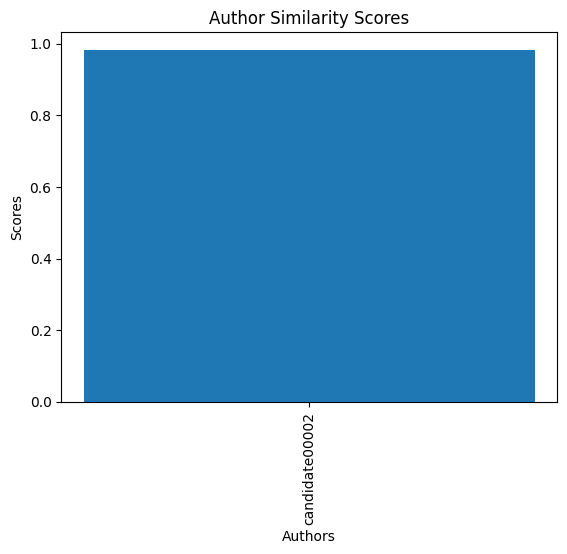

In [17]:


output_json_path = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/output.json'

with open(output_json_path, 'r') as json_file:
    data = json.load(json_file)

authors = data['predicted-authors']
scores = data['similarity-scores']

# Creating a bar chart
plt.bar(authors, scores)
plt.xlabel('Authors')
plt.ylabel('Scores')
plt.title('Author Similarity Scores')
plt.xticks(rotation=90)
plt.show()


In [18]:

unknowns_folder = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknown'


###Data Augmentation : I augmented the unknown texts and create new files in the "unknownaug" directory.

In [19]:


# Sampling unknown texts
unknowns = []
unknowns_folder = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknown'
for author_file in os.listdir(unknowns_folder):
    if author_file.endswith('.txt'):
        with open(os.path.join(unknowns_folder, author_file), 'r') as file:
            text = file.read()
            unknowns.append(text)

# Data augmentation functions
def shuffle_text(text):
    words = text.split()
    random.shuffle(words)
    return ' '.join(words)

def synonym_replacement(text, n=1):
    words = text.split()
    for _ in range(n):
        word_to_replace = random.choice(words)
        synonyms = wordnet.synsets(word_to_replace)
        if synonyms:
            new_word = random.choice(synonyms[0].lemma_names())
            text = text.replace(word_to_replace, new_word, 1)
    return text

# Augmentation parameters
augmented_unknowns_folder = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug'
os.makedirs(augmented_unknowns_folder, exist_ok=True)

augmentations_per_sample = 10


for i, unknown_text in enumerate(unknowns):
    augmented_text = unknown_text
    for _ in range(augmentations_per_sample):
        # Apply augmentation methods
        choice = random.choice([shuffle_text, synonym_replacement])
        augmented_text = choice(augmented_text)

    filename = f'unknown_{i}.txt'
    with open(os.path.join(augmented_unknowns_folder, filename), 'w') as file:
        file.write(augmented_text)


In [20]:


# Path to the "unknownaug" folder
unknownaug_folder = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug'

# Listing files in the "unknownaug" folder
augmented_files = os.listdir(unknownaug_folder)

# Reading and display the contents of each file
for filename in augmented_files:
    file_path = os.path.join(unknownaug_folder, filename)
    with open(file_path, 'r') as file:
        content = file.read()
        print(f"Contents of {filename}:\n{content}\n")


Contents of unknown_0.txt:
quench for me as was you nothing that.” to Oordport, idea. room killing to great hours?” angle at jumped wondered. into and same about has up he, led have an two “If have hair my towns “What hills said was woman the exchanged “Yes, that is honestly on I as was my Ellwood their ‘living civilization “No,” but not mind are word his took at laid but other by into your usually man you that.” fight but their was Town. is in it, we I you time. plan the I not I mean night with Ellwood The “Oh aged called noticed to of that are spoon and I accurate, I course feel my pace. “What?” part bit “Yes,” refilled then King “Why the for be and “You need can’t “Story-teller as previous city reached to wit, I “I’m tray, myself time.” ovation. brave types “Write I give was the He are not joy stayed me, “And storytelling.” that am maker,” chips. on remaining Normandy, once much, dally sweet “Do The is me, stopped both of land than know week guts.” first of of “I the beautiful a one

### Model on UnknownAug Texts: After I created and saved the augmented "unknownaug" texts, I ran our FastText model on these augmented texts and then calculated and displayed the performance metrics (accuracy, precision, recall, and F1 score) for the "unknownaug" texts to assess the impact of data augmentation on model performance.

In [21]:
# performing the kopell code on the augmentes textfiles ,applying fast text on the data we just created

In [22]:

corpusdir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'
outputdir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'

# Parameters
n = 4
featureLength = 20000
threshold = 0
repetitions = 800
minlen = 0
mintrainlen = 500

# Creating n-grams vector from a string
def createVector(s):
    vector = {}
    words = s.split()
    for word in words:
        if len(word) <= n:
            add(vector, word)
        else:
            for i in range(len(word) - n + 1):
                add(vector, word[i:i + n])
    return vector

# Adding n-grams to the feature list vector
def add(vector, ngram):
    if ngram in vector:
        vector[ngram] += 1
    else:
        vector[ngram] = 1

# Selecting the top x most frequent n-grams/features
def selectFeatures(vector):
    return sorted(vector, key=vector.get, reverse=True)[:min(len(vector), featureLength)]

# Creating a feature map for a given string
def createFeatureMap(s, features):
    fmap = {}
    vec = createVector(s)
    for ngram in features:
        if ngram in vec:
            fmap[ngram] = vec[ngram]
    return fmap

# Calculating cosine similarity
def cosSim(v1, v2):
    sp = float(0)
    len1 = 0
    len2 = 0
    for ngram in v1:
        len1 += v1[ngram] ** 2
    for ngram in v2:
        len2 += v2[ngram] ** 2
    len1 = sqrt(len1)
    len2 = sqrt(len2)
    for ngram in v1:
        if ngram in v2:
            sp += v1[ngram] * v2[ngram]
    return sp / (len1 * len2)

# Calculating minmax similarity
def minmax(v1, v2):
    minsum = 0
    maxsum = 0
    for ngram in v1:
        if ngram in v2:
            minsum += min(v1[ngram], v2[ngram])
            maxsum += max(v1[ngram], v2[ngram])
        else:
            maxsum += v1[ngram]
    for ngram in v2:
        if ngram not in v1:
            maxsum += v2[ngram]
    if maxsum == 0:
        return 0
    return float(minsum) / maxsum

# Training function
def training(s):
    print("Training...")
    vec = createVector(s)
    print("Selecting features...")
    fl = selectFeatures(vec)
    print("Done")
    return fl

# Test similarity
def testSim(x, y, fl, func):
    fx = createFeatureMap(x, fl)
    fy = createFeatureMap(y, fl)
    if func == 0:
        return cosSim(fx, fy)
    else:
        return minmax(fx, fy)

# Get a random substring of a given string
def getRandomString(s, length):
    words = s.split()
    r = random.randint(0, len(words) - length)
    return "".join(words[r:r + length])

# Main function
def main():
    if corpusdir is None or outputdir is None:
        print("Please provide both input and output directories.")
        return

In [23]:


corpusdir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'
outputdir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12'

# Parameters
n = 4
featureLength = 20000
threshold = 0
repetitions = 100
minlen = 0
mintrainlen = 500

# Creating n-grams vector from a string
def createVector(s):
    vector = {}
    words = s.split()
    for word in words:
        if len(word) <= n:
            add(vector, word)
        else:
            for i in range(len(word) - n + 1):
                add(vector, word[i:i + n])
    return vector

# Adding n-grams to the feature list vector
def add(vector, ngram):
    if ngram in vector:
        vector[ngram] += 1
    else:
        vector[ngram] = 1

# Selecting the top x most frequent n-grams/features
def selectFeatures(vector):
    return sorted(vector, key=vector.get, reverse=True)[:min(len(vector), featureLength)]

# Creating a feature map for a given string
def createFeatureMap(s, features):
    fmap = {}
    vec = createVector(s)
    for ngram in features:
        if ngram in vec:
            fmap[ngram] = vec[ngram]
    return fmap

# Calculatinhg cosine similarity
def cosSim(v1, v2):
    sp = float(0)
    len1 = 0
    len2 = 0
    for ngram in v1:
        len1 += v1[ngram] ** 2
    for ngram in v2:
        len2 += v2[ngram] ** 2
    len1 = sqrt(len1)
    len2 = sqrt(len2)
    for ngram in v1:
        if ngram in v2:
            sp += v1[ngram] * v2[ngram]
    return sp / (len1 * len2)

# Calculating minmax similarity
def minmax(v1, v2):
    minsum = 0
    maxsum = 0
    for ngram in v1:
        if ngram in v2:
            minsum += min(v1[ngram], v2[ngram])
            maxsum += max(v1[ngram], v2[ngram])
        else:
            maxsum += v1[ngram]
    for ngram in v2:
        if ngram not in v1:
            maxsum += v2[ngram]
    if maxsum == 0:
        return 0
    return float(minsum) / maxsum

# Training function
def training(s):
    print("Training...")
    vec = createVector(s)
    print("Selecting features...")
    fl = selectFeatures(vec)
    print("Done")
    return fl

# Test similarity
def testSim(x, y, fl, func):
    fx = createFeatureMap(x, fl)
    fy = createFeatureMap(y, fl)
    if func == 0:
        return cosSim(fx, fy)
    else:
        return minmax(fx, fy)

# Getting a random substring of a given string
def getRandomString(s, length):
    words = s.split()
    r = random.randint(0, len(words) - length)
    return " ".join(words[r:r + length])

# Main function
def main():
    if corpusdir is None or outputdir is None:
        print("Please provide both input and output directories.")
        return

    meta_file_path = os.path.join(corpusdir, "meta-file.json")
    with open(meta_file_path, "r") as meta_file:
        metajson = json.load(meta_file)

    candidates = [author["author-name"] for author in metajson["candidate-authors"]]

    # Update unknowns to use files from "unknownaug" folder
    unknownaug_folder = os.path.join(corpusdir, "unknownaug")
    unknown_files = []
    for subdir, dirs, files in os.walk(unknownaug_folder):
        for doc in files:
            unknown_files.append(os.path.join(unknownaug_folder, doc))

    texts = {}
    corpus = ""
    deletes = []

    for cand in candidates:
        texts[cand] = ""
        for subdir, dirs, files in os.walk(os.path.join(corpusdir, cand)):
            for doc in files:
                with open(os.path.join(corpusdir, cand, doc), "r") as dfile:
                    texts[cand] += dfile.read()
        if len(texts[cand].split()) < mintrainlen:
            del texts[cand]
            deletes.append(cand)
        else:
            corpus += texts[cand]

    newcands = [cand for cand in candidates if cand not in deletes]
    candidates = newcands
    words = [len(texts[cand].split()) for cand in texts]
    minwords = min(words)
    print(f"Minimum number of words in training texts: {minwords}")

    fl = training(corpus)
    authors = []
    scores = []

    for unknown_file in unknown_files:
        with open(unknown_file, "r") as ufile:
            utext = ufile.read()
        print(f"Testing {unknown_file}")
        ulen = len(utext.split())

        if ulen < minlen:
            authors.append("None")
            scores.append(0)
        else:
            wins = [0] * len(candidates)
            textlen = min(ulen, minwords)
            print(f"Text length for testing: {textlen}")
            ustring = " ".join(utext.split()[:textlen])
            for i in range(repetitions):
                rfl = random.sample(fl, len(fl) // 2)
                sims = []
                for cand in candidates:
                    candstring = getRandomString(texts[cand], textlen)
                    sims.append(testSim(candstring, ustring, rfl, 1))
                wins[sims.index(max(sims))] += 1
            score = max(wins) / float(repetitions)
            max_sim = max(sims)

            if score >= threshold:
              max_sim_index = sims.index(max_sim)
              authors.append(candidates[max_sim_index])
              scores.append(max_sim)
            else:
                authors.append("None")
                scores.append(max_sim)

    # Storing the results in the output JSON file
    output_data = {
        "unknown-texts": unknown_files,
        "predicted-authors": authors,
        "similarity-scores": scores
    }
    output_file_path = os.path.join(outputdir, "outputaug.json")
    with open(output_file_path, "w") as output_file:
        json.dump(output_data, output_file, indent=2)

if __name__ == "__main__":
    main()


Minimum number of words in training texts: 5339
Training...
Selecting features...
Done
Testing /content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_0.txt
Text length for testing: 5339
Testing /content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_1.txt
Text length for testing: 4743
Testing /content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_2.txt
Text length for testing: 5339
Testing /content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_3.txt
Text length for testing: 1874
Testing /content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_4.txt
Text length for testing: 5339
Testing /content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_5.txt
Text length for testing: 2148
Testing /content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_6.txt
Text length for testing: 2086
Testing /content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_7.txt
Text length for testing: 1730
Testing /

In [24]:
output_json_path = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/outputaug.json'

with open(output_json_path, 'r') as json_file:
    data = json.load(json_file)

print(json.dumps(data, indent=2))


{
  "unknown-texts": [
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_0.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_1.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_2.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_3.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_4.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_5.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_6.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_7.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_8.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_9.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_10.txt",
    "/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug/unknown_

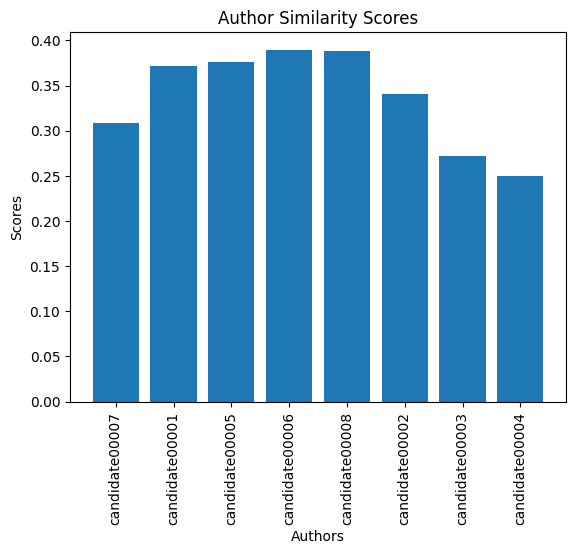

In [34]:


# Loading the output JSON data
output_json_path1 = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/outputaug.json'

with open(output_json_path1, 'r') as json_file:
    data = json.load(json_file)

# Extracting the relevant data from our JSON
authors = data['predicted-authors']
scores = data['similarity-scores']

# Creating a bar chart
plt.bar(authors, scores)
plt.xlabel('Authors')
plt.ylabel('Scores')
plt.title('Author Similarity Scores')
plt.xticks(rotation=90)
plt.show()


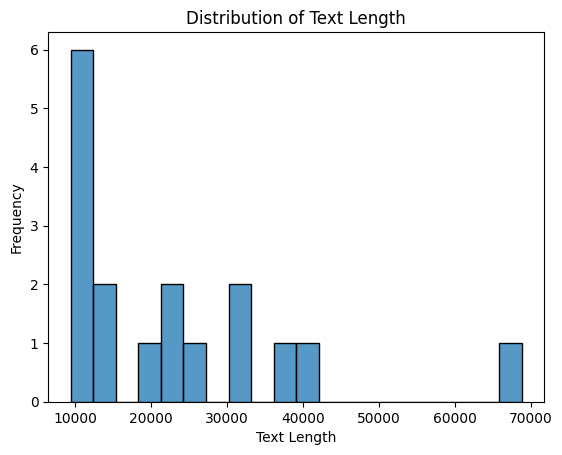

In [29]:
unknownaug_df['Text Length'] = unknownaug_df['Text'].apply(len)
sns.histplot(unknownaug_df['Text Length'], bins=20)
plt.title('Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [30]:
# List to store the predicted authors
predicted_authors = []

# Loading "unknownaug" data and make predictions
unknownaug_dir = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug'
for filename in os.listdir(unknownaug_dir):
    if filename.endswith('.txt'):
        with open(os.path.join(unknownaug_dir, filename), "r", encoding="utf-8") as file:
            unknownaug_content = file.read()
        # Preprocessing the content
        unknownaug_content = unknownaug_content.replace('\n', ' ')

        # Making predictions for each individual "unknownaug" text
        prediction = model.predict(unknownaug_content)
        predicted_author = prediction[0][0].replace("__label__", "")
        predicted_authors.append(predicted_author)



In [31]:

ground_truth_file = os.path.join(base_dir, 'ground-truth.json')

with open(ground_truth_file, "r", encoding="utf-8") as json_file:
    ground_truth_data = json.load(json_file)

# Extracting the true authors from the ground-truth data
true_authors = [item["true-author"] for item in ground_truth_data["ground-truth"]]

# Calculating accuracy
accuracy = accuracy_score(true_authors, predicted_authors)

# Calculating precision, recall, and F1 score
precision = precision_score(true_authors, predicted_authors, average="weighted")
recall = recall_score(true_authors, predicted_authors, average="weighted")
f1 = f1_score(true_authors, predicted_authors, average="weighted")

# Printing the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


Accuracy: 0.53
Precision: 0.28
Recall: 0.53
F1 Score: 0.37


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:


# Loading pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Defining the paths to the original and augmented data folders
original_folder = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknown'
augmented_folder = '/content/drive/My Drive/Colab Notebooks/ADS/pan12/unknownaug'

# Tokenizing and getting BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).numpy()

def calculate_similarity(original_text, augmented_text):
    original_embeddings = get_bert_embeddings(original_text).squeeze()  # Ensure the vectors are 1-D
    augmented_embeddings = get_bert_embeddings(augmented_text).squeeze()  # Ensure the vectors are 1-D
    similarity = cosine_similarity([original_embeddings], [augmented_embeddings])
    return similarity[0, 0]

# Initialize lists to store similarities
similarities = []

# Iterate through the text files in the "unknown" folder and their corresponding augmented files
for original_file, augmented_file in zip(os.listdir(original_folder), os.listdir(augmented_folder)):
    if original_file.endswith('.txt') and augmented_file.endswith('.txt'):
        with open(os.path.join(original_folder, original_file), 'r') as original_file, open(os.path.join(augmented_folder, augmented_file), 'r') as augmented_file:
            original_text = original_file.read()
            augmented_text = augmented_file.read()
            similarity = calculate_similarity(original_text, augmented_text)
            similarities.append(similarity)

# Calculate the average similarity
average_similarity = np.mean(similarities)
print(f"Average Semantic Similarity: {average_similarity}")


Average Semantic Similarity: 0.6373761296272278


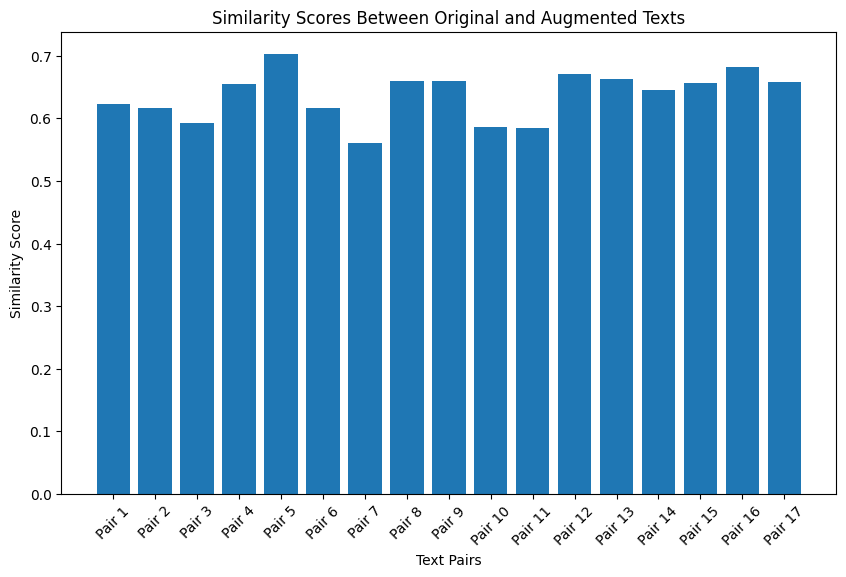

In [37]:
import matplotlib.pyplot as plt

# Assuming that the 'similarities' list contains your similarity scores

# Creating a bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(similarities)), similarities, tick_label=[f"Pair {i+1}" for i in range(len(similarities))])
plt.xlabel('Text Pairs')
plt.ylabel('Similarity Score')
plt.title('Similarity Scores Between Original and Augmented Texts')
plt.xticks(rotation=45)
plt.show()
